# This analysis reviews the dates mail-in ballots were sent out and returned to their respective county election boards in Pennsylvnia for the June 2 Primary. 
# Data is from the Pennsylvania Department of State, obtained through the state's open [data portal](https://data.pa.gov/browse?q=ballot&sortBy=relevance). County map files were downloaded from the same source

### First, we'll read in our modules. I'm mostly relying on a list of Python tools I often use for any analysis. Not all are necessary, but I find I end up using most of these at one point or another.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib import colors
import numpy as np
import datetime as dt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

### Next, we'll import the ballot data csv and the county map from the data portal, followed with a quck spot check to see if it worked.

In [2]:
#The data portal shows this data was last updated on Sept. 25
primary_ballots=pd.read_csv("2020_Primary_Election_Mail_Ballot_Requests_Department_of_State.csv")
primary_ballots.head()

,County Name,Applicant Party Designation,Date of Birth,Mail Application Type,Application Request Date,Application Approved Date,Ballot Mailed Date,Ballot Returned Date,State House District,State Senate District,Congressional District
0,ADAMS,D,04/06/1981,OLMAILV,04/29/2020,04/29/2020,04/30/2020,NaN,91ST LEGISLATIVE DISTRICT,33RD SENATORIAL DISTRICT,13TH CONGRESSIONAL DISTRICT
1,ADAMS,R,03/25/1969,OLREGV,05/05/2020,05/05/2020,05/07/2020,05/21/2020,91ST LEGISLATIVE DISTRICT,33RD SENATORIAL DISTRICT,13TH CONGRESSIONAL DISTRICT
2,ADAMS,R,05/15/1968,OLREGV,05/06/2020,05/06/2020,05/07/2020,05/21/2020,91ST LEGISLATIVE DISTRICT,33RD SENATORIAL DISTRICT,13TH CONGRESSIONAL DISTRICT
3,MONTGOMERY,D,02/20/1938,MAILIN,05/15/2020,05/15/2020,05/16/2020,05/28/2020,61ST LEGISLATIVE DISTRICT,24TH SENATORIAL DISTRICT,4TH CONGRESSIONAL DISTRICT
4,DELAWARE,D,09/04/1958,OLMAILV,05/06/2020,05/06/2020,05/11/2020,06/01/2020,159TH LEGISLATIVE DISTRICT,9TH SENATORIAL DISTRICT,5TH CONGRESSIONAL DISTRICT


In [3]:
#The data portal shows this data was last updated on Sept. 25
primary_ballots.shape

(1823148, 11)

<AxesSubplot:>

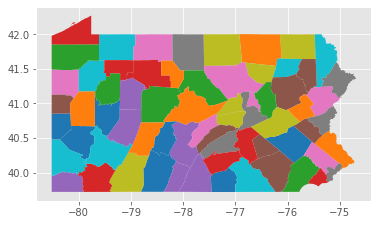

In [4]:
countymap=gpd.read_file("https://data.pa.gov/resource/2axz-wupj.geojson")
countymap.plot(column='county_nam')

In [5]:
countymap.shape

(67, 26)

### I'm renaming the columns to remove white space and put the column headers in lower case, then converting the date columns to a datetime object. We'll merge with the map when we move to a geospatial analysis.

In [6]:
primary_ballots.columns=primary_ballots.columns.str.replace(" ","_").str.lower()
primary_ballots['date_of_birth']=pd.to_datetime(primary_ballots.date_of_birth,errors='ignore',format='%m/%d/%Y')
primary_ballots['application_request_date']=pd.to_datetime(primary_ballots.application_request_date,errors='ignore',format='%m/%d/%Y')
primary_ballots['ballot_mailed_date']=pd.to_datetime(primary_ballots.ballot_mailed_date,errors='ignore',format='%m/%d/%Y')
primary_ballots['ballot_returned_date']=pd.to_datetime(primary_ballots.ballot_returned_date,errors='ignore',format='%m/%d/%Y')

In [7]:
((primary_ballots[primary_ballots.ballot_returned_date.isna()].applicant_party_designation.count()/primary_ballots.applicant_party_designation.count()).round(3))*100

19.8

# About 20% of mail-in ballots requested in the June 2 primary were never returned to their respective election board headquarters.

In [8]:
primary_ballots['time_to_return']=(primary_ballots['ballot_returned_date'] - primary_ballots['ballot_mailed_date']).dt.days

In [9]:
primary_ballots[primary_ballots.time_to_return>0].time_to_return.describe().round(2)

count    1459876.00
mean          16.92
std           10.61
min            1.00
25%           10.00
50%           15.00
75%           21.00
max          141.00
Name: time_to_return, dtype: float64

# It appears that it took an average of nearly 17 days ballots to be returned after being mailed out. The median length of time was 15 days. 

In [10]:
primaryday=pd.to_datetime('2020-06-02')
primary_ballots[(primary_ballots.ballot_returned_date>primaryday)&(primary_ballots.time_to_return>0)].time_to_return.describe().round(2)

count    98198.00
mean        17.79
std         11.51
min          1.00
25%         10.00
50%         15.00
75%         22.00
max        121.00
Name: time_to_return, dtype: float64

In [11]:
primary_ballots[(primary_ballots.ballot_returned_date<primaryday)&(primary_ballots.time_to_return>0)].time_to_return.describe().round(2)

count    1272808.00
mean          17.00
std           10.51
min            1.00
25%           10.00
50%           15.00
75%           21.00
max          112.00
Name: time_to_return, dtype: float64

In [12]:
(primary_ballots[(primary_ballots.ballot_returned_date==primaryday)&(primary_ballots.time_to_return>0)].time_to_return.describe().round(2)[0]/primary_ballots.county_name.count()).round(4)*100

4.87

# Ballots returned before or after the primary typically took about 15 days. Ballots returned after June 2 did have a slightly higher average than ones returned before June 2.
# The 88,870 ballots returned on election day, however, saw roughly an 11 day turnaround, and an average time under the median time for the other examples. 
# These could have all been returned to drop boxes on June 2, but I'm not sure how we'd account for that. 
# I do think it's worth noting that only about 4.8% of total ballots requested would have been returned on the primary. I suspect day-of returns will have some interestng party, demographic and county level analysis.

In [13]:
primary_ballots.sort_values(by=['county_name','ballot_returned_date'],inplace=True)

### Before we go any further, we should explain the different kinds of ballots involved here.
### Overall, the data is for vote-by-mail ballots, which is essentially an expansion of the regular Absentee Ballot the commonwealth has used since before the American Civil War. 
### The state implemened a "no-excuse" mail-in ballot system earlier in 2020. The ballots were basically the same as the regular mail-in ballot system, just expanded to include residents who live in their precincts during an election.

OLMAILV    1001676
MAILIN      501038
OLREGV      268162
REG          39191
CIV           3586
CVO           2940
F             2579
M             2248
PER            925
ALT            282
C              202
PMI            165
BV              78
CRI             45
MRI             27
V                4
Name: mail_application_type, dtype: int64


<AxesSubplot:>

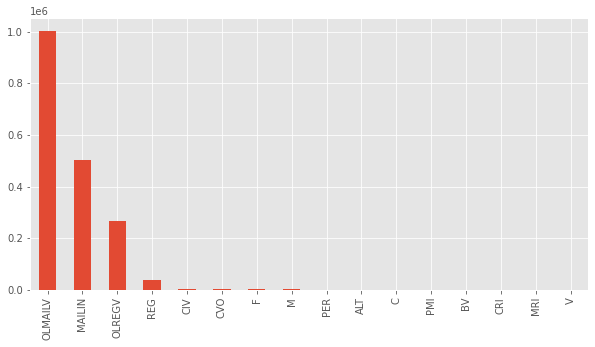

In [14]:
print(primary_ballots.mail_application_type.value_counts())
primary_ballots.mail_application_type.value_counts().plot(kind='bar',figsize=(10,5))

### "OLMAILV" are the most common kind of ballot, just over 1 million of all ballots. These are just mail-in ballot appications that were created online. The second most popular application (about half the number of online applications) is a standard mail-in ballot application, followed by a typical absentee ballot for civilians. That OLREGV ballot is about half the number of regular balots requested. 
### So, overall, traditional absentee ballots (both for whose in the military or civilians living outside their precinct) make up little less than 20% of all the ballots in this data.

In [16]:
primary_ballots['week']=primary_ballots.ballot_returned_date.dt.week

In [88]:
print(primary_ballots[primary_ballots.ballot_returned_date.dt.week==22].shape)
primary_ballots[primary_ballots.ballot_returned_date.dt.week==22].ballot_returned_date.value_counts().sort_index()

(549839, 13)


2020-05-25     34500
2020-05-26     78648
2020-05-27     68928
2020-05-28    134258
2020-05-29    119418
2020-05-30     66286
2020-05-31     47801
Name: ballot_returned_date, dtype: int64

In [17]:
ttr1=primary_ballots.groupby([primary_ballots.ballot_returned_date.dt.week]).time_to_return.sum().to_frame().reset_index().rename(columns={'time_to_return':'total_weeks'})
ttr2=primary_ballots.groupby([primary_ballots.ballot_returned_date.dt.week]).time_to_return.count().to_frame().reset_index().rename(columns={'time_to_return':'total_ballots'})
ttr3=pd.merge(ttr1,ttr2,on='ballot_returned_date')
ttr3['ave_ttr']=ttr3.total_weeks/ttr3.total_ballots

### The charts below show the average number of days it took ballots to return to the counties each week. Some took longer than others, but generally it took ballots about two weeks to go to the voter and for the voter to send them back.

<AxesSubplot:xlabel='ballot_returned_date'>

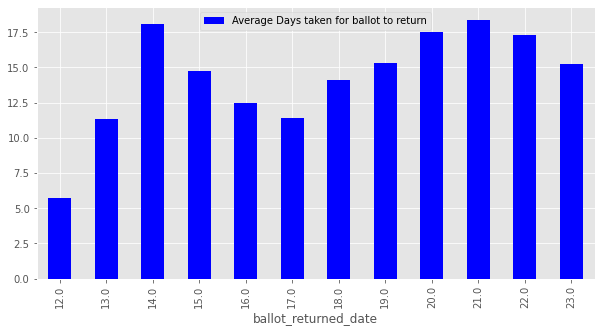

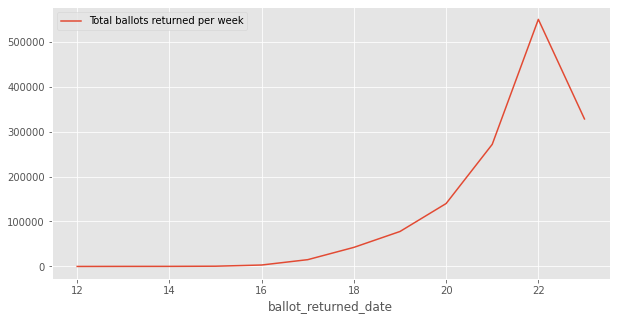

In [18]:
ttr3[(ttr3.ballot_returned_date>11)&(ttr3.ballot_returned_date<=23)].plot(kind='bar',x='ballot_returned_date',
                                                                         y='ave_ttr', legend=True, 
                                                                         label='Average Days taken for ballot to return',
                                                                         figsize=(10,5),color='blue')
ttr3[(ttr3.ballot_returned_date>11)&(ttr3.ballot_returned_date<=23)].plot(kind='line',x='ballot_returned_date',
                                                                         y='total_ballots',legend=True,
                                                                         label='Total ballots returned per week',
                                                                         figsize=(10,5))

### While the number of ballots returned increased at a near exponential rate in the weeks leading up to the primary, the average mail time for those ballots saw minor increases.

### I want a dataframe that will ultimately tell us what the average and median ballot return time was in each county for each day for a map. This will allow us to look at the overall median or average for a variety of ranges.
### I tried this before just taking all of the dates, but it was a bit off. The problem was that people who asked for a ballot back in March or April were included. While that's generally useful information to have, I think we really need to know more about ballots accepted closer to election day, and how those were recieved. We're going to filter out rows where the application request date is greater than 30 days before the primary.

In [19]:
primary_ballots[primary_ballots.application_request_date>=(primaryday-pd.DateOffset(days=30))].shape

(1012784, 13)

### We'll start with the geospatial anaylsis here as well. First we're going to create a dataframe containing the daily mean and average number of days to return a ballot for applications received a month before the primary. 

In [20]:
cty_ttr1=primary_ballots[primary_ballots.application_request_date>=(primaryday-pd.DateOffset(days=30))].groupby(["county_name",'ballot_returned_date']).time_to_return.median().to_frame().reset_index().rename(columns={'time_to_return':'ttr_median'})
cty_ttr2=primary_ballots[primary_ballots.application_request_date>=(primaryday-pd.DateOffset(days=30))].groupby(["county_name",'ballot_returned_date']).time_to_return.mean().to_frame().reset_index().rename(columns={'time_to_return':'ttr_mean'})
cty_ttr3=pd.merge(cty_ttr1,cty_ttr2,on=['county_name','ballot_returned_date'])
countymap=gpd.read_file("https://data.pa.gov/resource/2axz-wupj.geojson")
countymap=countymap[['county_nam',"geometry"]]
countymap.rename(columns={'county_nam':'county_name'},inplace=True)
countymap['county_name']=countymap.county_name.str.upper()
cty_ttr3['county_name']=cty_ttr3.county_name.str.upper()
cty_ttr_map=pd.merge(countymap,cty_ttr3,on='county_name')

In [90]:
cty_ttr_map[(cty_ttr_map.ballot_returned_date==primaryday)&(cty_ttr_map.ttr_median>0)].ttr_median.describe()

count    67.000000
mean     11.201493
std       3.141920
min       5.000000
25%      10.000000
50%      11.000000
75%      13.000000
max      26.000000
Name: ttr_median, dtype: float64

### Based on those criteria, the average time to return a ballot was about 11 days, while most came in just under two weeks. Some took as along as 26 days to return, but we also don't know for certain when the voters mailed them out. This may also include ballots left at drop boxes, but the data doesn't indicate either way.

/Users/ulleryc/data-projects/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if sys.path[0] == '':


<AxesSubplot:title={'center':'Median days to arrive for ballots recorded on June 2\n for ballots requested 30 days before Primary'}>

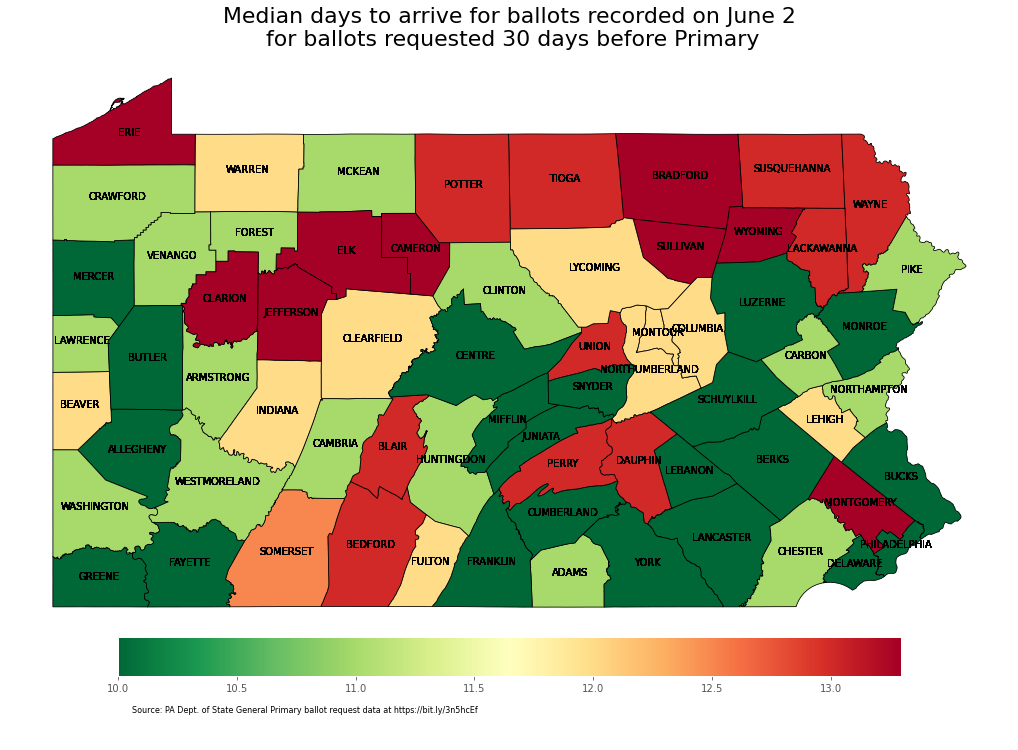

In [213]:
variable='ttr_median'
vmin=cty_ttr_map[cty_ttr_map.ballot_returned_date==primaryday].ttr_median.describe()[4]
vmax=(cty_ttr_map[cty_ttr_map.ballot_returned_date==primaryday].ttr_median.describe()[1])+(cty_ttr_map[cty_ttr_map.ballot_returned_date==(primaryday-pd.DateOffset(days=1))].ttr_median.describe()[2])
#colormap1=colors.ListedColormap(['#FFA805','#F08906','#FF7800','#FF4D00','#FF0000','#9B2100'])
colormap1='RdYlGn_r'
fig, ax = plt.subplots(1,figsize=(18,12))
ax.axis("off")
ax.set_title('Median days to arrive for ballots recorded on '+(primaryday).month_name()+" "+str((primaryday).day)+"\n for ballots requested 30 days before Primary",fontdict={'fontsize':'22','fontweight':'10','color':'black'})
#ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
ax.annotate("Source: PA Dept. of State General Primary ballot request data at https://bit.ly/3n5hcEf",
            xy=(0.13,.05),xycoords='figure fraction',fontsize=8,color='black')
cty_ttr_map.apply(lambda x: ax.annotate(s=x.county_name, xy=x.geometry.centroid.coords[0], ha='center',color='black',fontsize=10),axis=1);
sm = plt.cm.ScalarMappable(cmap=colormap1,
                          norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, orientation='horizontal',fraction=0.06,pad=.005,aspect=20,)
cty_ttr_map[(cty_ttr_map.ballot_returned_date==primaryday)&(cty_ttr_map.ttr_median>0)].plot(column=variable, cmap=colormap1,vmin=vmin,vmax=vmax,linewidth=0.8,ax=ax, edgecolor='black')


/Users/ulleryc/data-projects/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if sys.path[0] == '':


<AxesSubplot:title={'center':'Average days to arrive for ballots recorded on June 2\n for ballots requested 30 days before Primary'}>

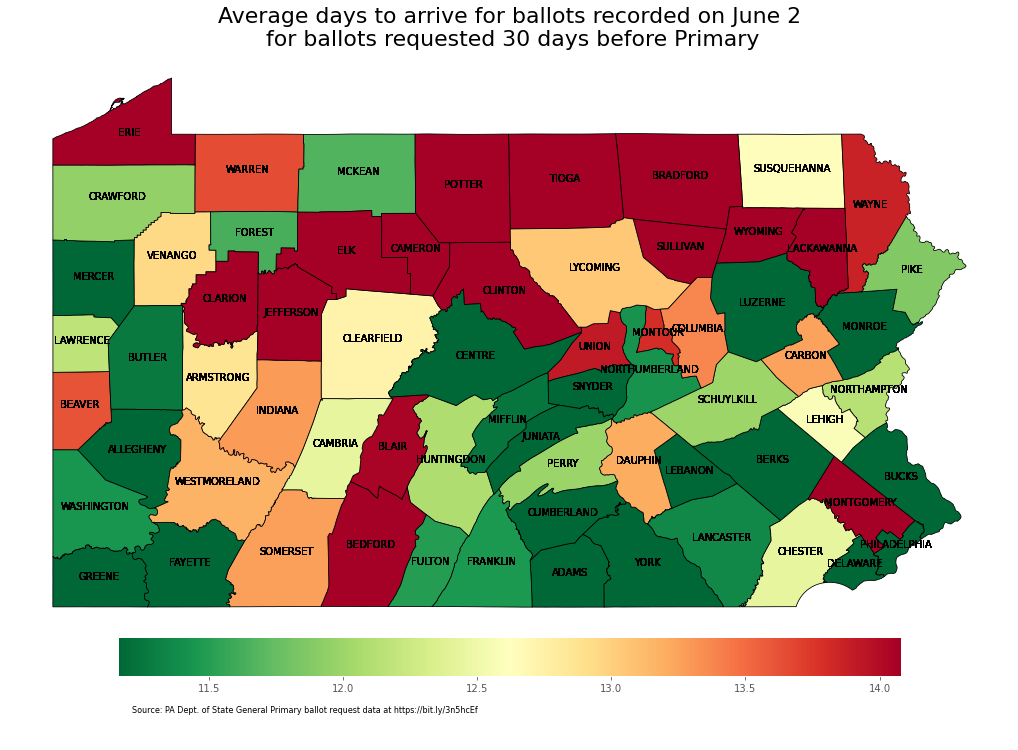

In [214]:
variable='ttr_mean'
vmin=cty_ttr_map[cty_ttr_map.ballot_returned_date==primaryday].ttr_mean.describe()[4]
vmax=(cty_ttr_map[cty_ttr_map.ballot_returned_date==primaryday].ttr_mean.describe()[1])+(cty_ttr_map[cty_ttr_map.ballot_returned_date==(primaryday-pd.DateOffset(days=1))].ttr_mean.describe()[2])
#colormap1=colors.ListedColormap(['#FFA805','#F08906','#FF7800','#FF4D00','#FF0000','#9B2100'])
colormap1='RdYlGn_r'
fig, ax = plt.subplots(1,figsize=(18,12))
ax.axis("off")
ax.set_title('Average days to arrive for ballots recorded on '+(primaryday).month_name()+" "+str((primaryday).day)+"\n for ballots requested 30 days before Primary",fontdict={'fontsize':'22','fontweight':'10','color':'black'})
#ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
ax.annotate("Source: PA Dept. of State General Primary ballot request data at https://bit.ly/3n5hcEf",
            xy=(0.13,.05),xycoords='figure fraction',fontsize=8,color='black')
cty_ttr_map.apply(lambda x: ax.annotate(s=x.county_name, xy=x.geometry.centroid.coords[0], ha='center',color='black',fontsize=10),axis=1);
sm = plt.cm.ScalarMappable(cmap=colormap1,
                          norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, orientation='horizontal',fraction=0.06,pad=.005,aspect=20,)
cty_ttr_map[(cty_ttr_map.ballot_returned_date==primaryday)&(cty_ttr_map.ttr_mean>0)].plot(column=variable, cmap=colormap1,vmin=vmin,vmax=vmax,linewidth=0.8,ax=ax, edgecolor='black')


### The maps above show the median number of days and the average number of days for ballots to return on June 2 using our 30-day filter. Counties in northern and central Pennsylvania usually had the longer wait times, though Montgomery County and Beaver County in the southeast and western parts of the state were also slightly higher than average.
### Montgomery County had a few problems with about 6,000 ballots needing to be canceled, and this could be skewing their numbers a bit.

In [25]:
primary_ballots[(primary_ballots.ballot_returned_date==primaryday)].ballot_returned_date.value_counts().sort_index()#.applicant_party_designation

2020-06-02    89013
Name: ballot_returned_date, dtype: int64

### About 89,000 ballots were returned on June 2 alone.

# Party Break Down

### I thought I'd remove our time constraints for the party breakdown. The time it takes to send a ballot back is probably going to have more to do with geography than party. Since Pennsylvania is a closed primary state, we're just going to focus on ballots for Democrats and Republicans. 

/Users/ulleryc/data-projects/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


<AxesSubplot:>

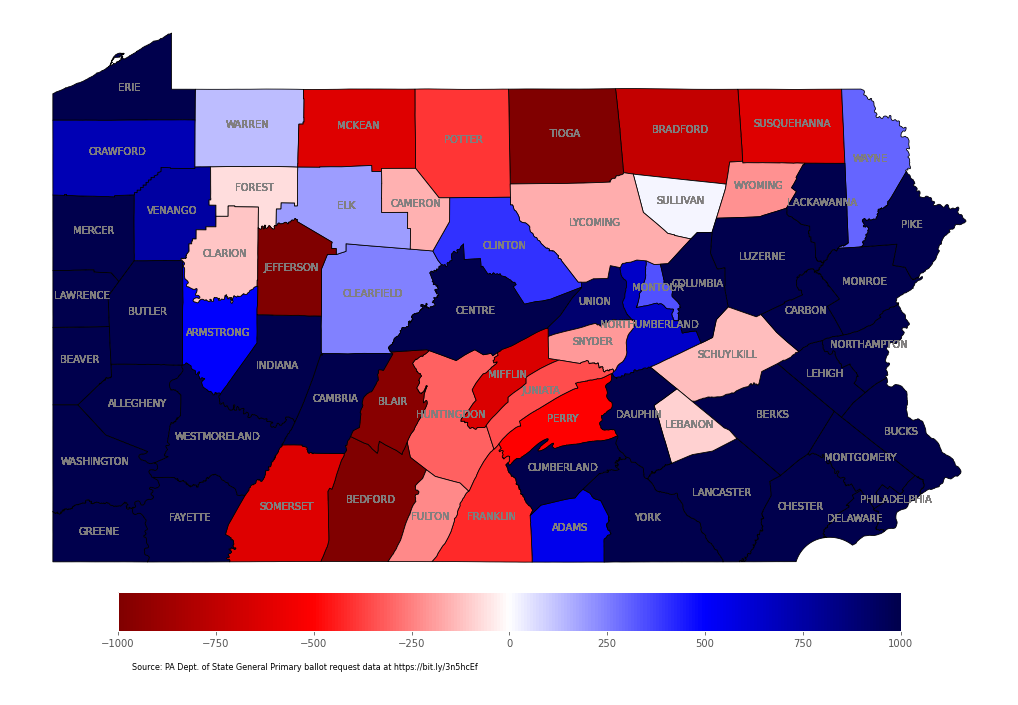

In [140]:
prim_dems=primary_ballots[primary_ballots.applicant_party_designation=='D'].county_name.value_counts().to_frame().reset_index().rename(columns={'county_name':'dems','index':'county_name'})
prim_dems['county_name']=prim_dems.county_name.str.upper()
prim_reps=primary_ballots[primary_ballots.applicant_party_designation=='R'].county_name.value_counts().to_frame().reset_index().rename(columns={'county_name':'reps','index':'county_name'})
prim_reps['county_name']=prim_reps.county_name.str.upper()
cty_prim_parties=pd.merge(prim_dems,prim_reps,on='county_name')
cty_prim_map['county_name']=cty_prim_parties.county_name.str.upper()
cty_prim_map=pd.merge(countymap,cty_prim_parties)
cty_prim_map['dVr']=cty_prim_map.dems-cty_prim_map.reps
variable='dVr'
vmin=-1000
vmax=1000
colormap1='seismic_r'#colors.ListedColormap(['#FE0000','#FC0202','#DA170A','#DE191E','#DE1190','#45319D','#154FCA','#0555FF','#0567FF'])
fig, ax = plt.subplots(1,figsize=(18,12))
ax.axis("off")
ax.annotate("Source: PA Dept. of State General Primary ballot request data at https://bit.ly/3n5hcEf",
            xy=(0.13,.05),xycoords='figure fraction',fontsize=8,color='black')
cty_ttr_map.apply(lambda x: ax.annotate(s=x.county_name, xy=x.geometry.centroid.coords[0], ha='center',color='#817F7F',fontsize=10),axis=1);
sm = plt.cm.ScalarMappable(cmap=colormap1,
                          norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, orientation='horizontal',fraction=0.06,pad=.005,aspect=20,)
cty_prim_map.plot(column=variable, cmap=colormap1,vmin=vmin,vmax=vmax,linewidth=0.8,ax=ax,edgecolor='black')

### The map above is looking at all ballot applications sent in for the two parties, then comparing the number of Democratic and Republican applications. I set the minimum and maximum for our color chart to -1000 and 1000 because Republicans only led by about 1,600 applications. I thought setting the color bar at those limits would more accurately present the leads in each county. Many blue counties have Democrats outnumbering Republicans in upwards of several thousand voters.

/Users/ulleryc/data-projects/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


<AxesSubplot:>

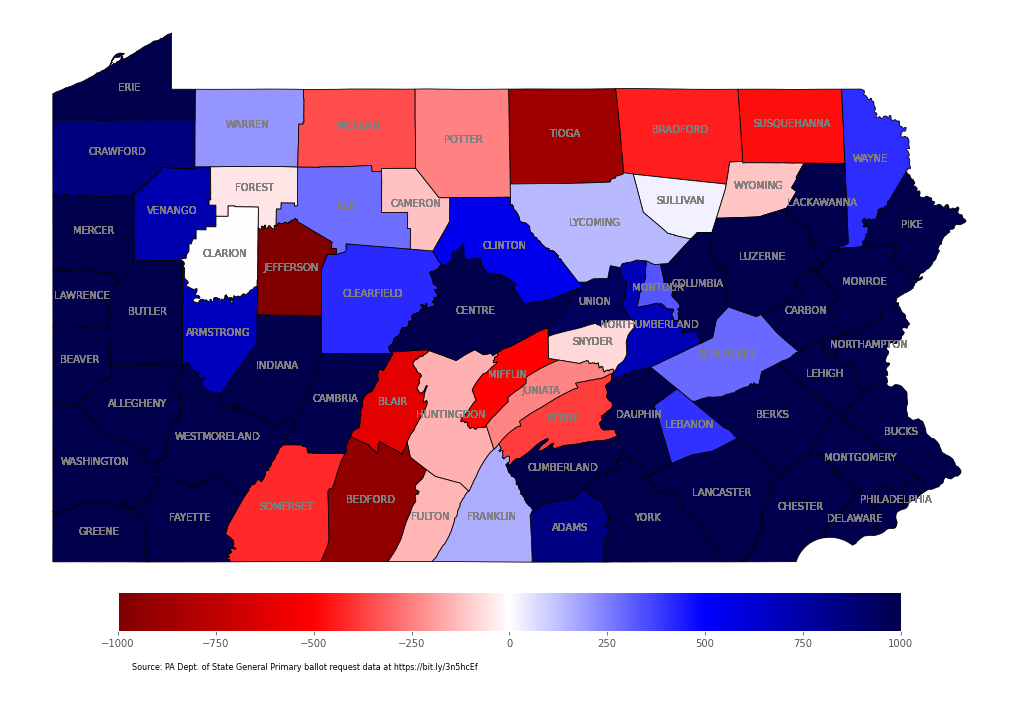

In [142]:
prim_dems=primary_ballots[(primary_ballots.applicant_party_designation=='D')&(primary_ballots.ballot_returned_date.notna())].county_name.value_counts().to_frame().reset_index().rename(columns={'county_name':'dems','index':'county_name'})
prim_dems['county_name']=prim_dems.county_name.str.upper()
prim_reps=primary_ballots[(primary_ballots.applicant_party_designation=='R')&(primary_ballots.ballot_returned_date.notna())].county_name.value_counts().to_frame().reset_index().rename(columns={'county_name':'reps','index':'county_name'})
prim_reps['county_name']=prim_reps.county_name.str.upper()
cty_prim_parties=pd.merge(prim_dems,prim_reps,on='county_name')
cty_prim_map['county_name']=cty_prim_parties.county_name.str.upper()
cty_prim_map=pd.merge(countymap,cty_prim_parties)
cty_prim_map['dVr']=cty_prim_map.dems-cty_prim_map.reps
variable='dVr'
vmin=-1000
vmax=1000
colormap1='seismic_r'#colors.ListedColormap(['#FE0000','#FC0202','#DA170A','#DE191E','#DE1190','#45319D','#154FCA','#0555FF','#0567FF'])
fig, ax = plt.subplots(1,figsize=(18,12))
ax.axis("off")
ax.annotate("Source: PA Dept. of State General Primary ballot request data at https://bit.ly/3n5hcEf",
            xy=(0.13,.05),xycoords='figure fraction',fontsize=8,color='black')
cty_ttr_map.apply(lambda x: ax.annotate(s=x.county_name, xy=x.geometry.centroid.coords[0], ha='center',color='#817F7F',fontsize=10),axis=1);
sm = plt.cm.ScalarMappable(cmap=colormap1,
                          norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, orientation='horizontal',fraction=0.06,pad=.005,aspect=20,)
cty_prim_map.plot(column=variable, cmap=colormap1,vmin=vmin,vmax=vmax,linewidth=0.8,ax=ax,edgecolor='black')

### This is similar to the previous map, but I excluded applications that didn't come back at all. It's effectively a comparison of mail-in ballots cast by party and county. The most notable changes bewteen the two are the number of counties where red led blue. A handful of GOP-led counties ended up having more Democrats following through on their mail-in ballots. 
### Voters could have applied for a mail-in ballot, but ultimately chose to cast a ballot in person. A [report](https://www.dos.pa.gov/VotingElections/Documents/2020-08-01-Act35Report.pdf) from the PA Dept. of State estimated more than 42,000 people who applied for a mail-in ballot cast a vote through a provisional ballot at the polls on June 2.

# General Election Ballot Update
### The state announced Monday afternoon the state's data portal had the applicaitons for ballots in the November election. Voters could request a ballot for the Presidential Election when they filed for primary ballot. I wanted to quickly compare the party line voters now. I'm just recycling the code from the party maps above to fit the new data.

/Users/ulleryc/data-projects/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ulleryc/data-projects/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


<AxesSubplot:>

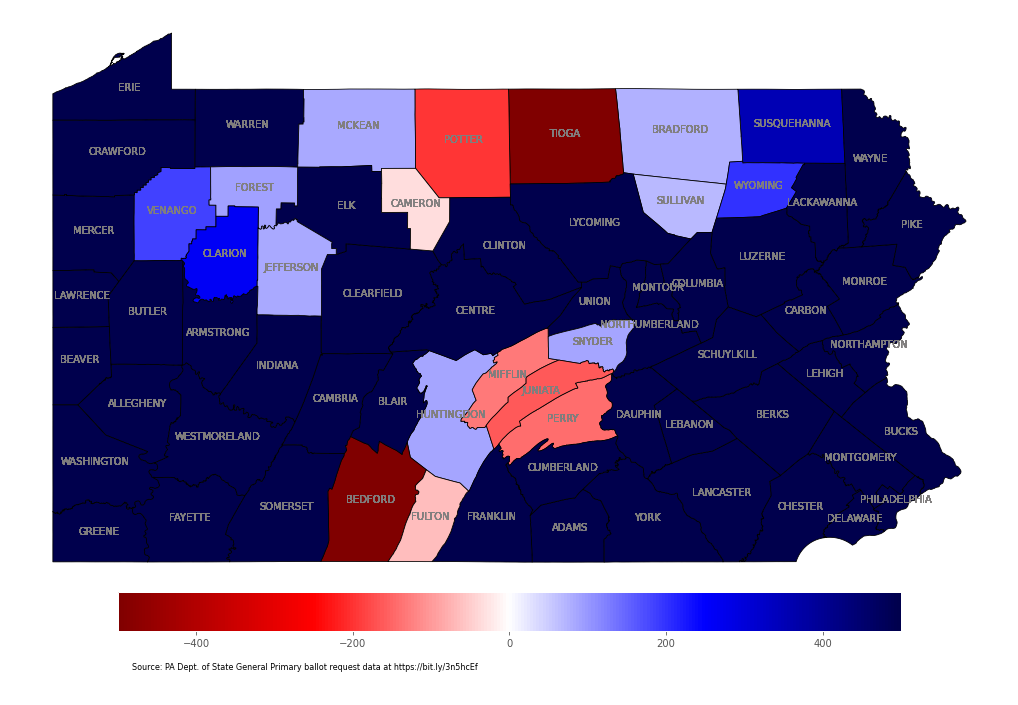

In [215]:
gen_el=pd.read_csv('2020_General_Election_Mail_Ballot_Requests_Department_of_State.csv')
gen_el.columns=gen_el.columns.str.replace(" ","_").str.lower()
gen_el['date_of_birth']=pd.to_datetime(gen_el.date_of_birth,errors='ignore',format='%m/%d/%Y')
#gen_el['application_request_date']=pd.to_datetime(gen_el.application_request_date,errors='ignore',format='%m/%d/%Y')
gen_el['ballot_mailed_date']=pd.to_datetime(gen_el.ballot_mailed_date,errors='ignore',format='%m/%d/%Y')
gen_el['ballot_returned_date']=pd.to_datetime(gen_el.ballot_returned_date,errors='ignore',format='%m/%d/%Y')
gendems=gen_el[gen_el.applicant_party_designation=='D'].county_name.value_counts().to_frame().reset_index().rename(columns={'county_name':'dems','index':'county_name'})
gendems['county_name']=gendems.county_name.str.upper()
genreps=gen_el[gen_el.applicant_party_designation=='R'].county_name.value_counts().to_frame().reset_index().rename(columns={'county_name':'reps','index':'county_name'})
genreps['county_name']=genreps.county_name.str.upper()
otherparties=['R','D']
genother=gen_el[~gen_el.applicant_party_designation.isin(otherparties)].county_name.value_counts().to_frame().reset_index().rename(columns={'county_name':'other','index':'county_name'})
genother['county_name']=genother.county_name.str.upper()
cty_genparties=pd.merge(gendems,genreps,on='county_name')
cty_genparties=pd.merge(cty_genparties,genother,on='county_name')
#countymap['county_name']=countymap.county_name.str.upper()
cty_genmap['county_name']=cty_genparties.county_name.str.upper()
cty_genmap=pd.merge(countymap,cty_genparties)
cty_genmap['dVr']=cty_genmap.dems-cty_genmap.reps
variable='dVr'
vmin=-500
vmax=500
colormap1='seismic_r'#colors.ListedColormap(['#FE0000','#FC0202','#DA170A','#DE191E','#DE1190','#45319D','#154FCA','#0555FF','#0567FF'])
fig, ax = plt.subplots(1,figsize=(18,12))
ax.axis("off")
ax.annotate("Source: PA Dept. of State General Primary ballot request data at https://bit.ly/3n5hcEf",
            xy=(0.13,.05),xycoords='figure fraction',fontsize=8,color='black')
cty_ttr_map.apply(lambda x: ax.annotate(s=x.county_name, xy=x.geometry.centroid.coords[0], ha='center',color='#817F7F',fontsize=10),axis=1);
sm = plt.cm.ScalarMappable(cmap=colormap1,
                          norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, orientation='horizontal',fraction=0.06,pad=.005,aspect=20,)
cty_genmap.plot(column=variable, cmap=colormap1,vmin=vmin,vmax=vmax,linewidth=0.8,ax=ax,edgecolor='black')

### I set the colorbar in this map to -500 and 500. The highest Republican led county had a little over 600 GOP voters, while Democrats again see leads several times greater in some counties. 